In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older t

In [9]:
dim_reduced_df = pd.read_csv('df_2_reduced.csv')

In [10]:
dim_reduced_df.shape

(700, 52)

In [11]:
# -----------------------------
# CONFIG
# -----------------------------
financial_indicators = [
    '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', 
    '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 
    'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
]

recession_targets = [
    'recession_probability', '1_month_recession_probability',
    '3_month_recession_probability', '6_month_recession_probability'
]

In [12]:

# -----------------------------
# DATA SPLIT
# -----------------------------
def prepare_data_split(df, date_col='date', split_year=2020):
    df[date_col] = pd.to_datetime(df[date_col])
    df_sorted = df.sort_values(date_col).reset_index(drop=True)
    train_data = df_sorted[df_sorted[date_col].dt.year < split_year].copy()
    test_data = df_sorted[df_sorted[date_col].dt.year >= split_year].copy()
    print(f"Training: {len(train_data)} rows | Testing: {len(test_data)} rows")
    return train_data, test_data

# -----------------------------
# MLP FORECAST FUNCTION
# -----------------------------
def forecast_with_mlp(train_df, test_df, target, exog_cols=None, epochs=500, batch_size=16):
    print(f"\n{'='*50}")
    print(f"MLP Forecasting: {target}")
    print(f"{'='*50}")

    # Prepare X and y
    features = exog_cols if exog_cols else []
    X_train = train_df[features].values if features else np.arange(len(train_df)).reshape(-1,1)
    y_train = train_df[target].values
    X_test = test_df[features].values if features else np.arange(len(test_df)).reshape(-1,1)
    y_test = test_df[target].values

    # Clean missing/infinite values
    X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
    X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
    y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)
    y_test = np.nan_to_num(y_test, nan=0.0, posinf=0.0, neginf=0.0)

    # Scale features
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1))
    
    # -----------------------------
    # Build simple MLP
    # -----------------------------
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # Train
    history = model.fit(
        X_train_scaled, y_train_scaled, 
        validation_split=0.2, 
        epochs=epochs, 
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    # Predict
    y_pred_scaled = model.predict(X_test_scaled).flatten()
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred)/np.maximum(np.abs(y_test),1e-8)))*100

    print(f"📊 Results: MAE={mae:.4f}, RMSE={rmse:.4f}, MAPE={mape:.2f}%")

    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(test_df['date'], y_test, label='Actual', color='blue')
    plt.plot(test_df['date'], y_pred, label='Forecast', color='red')
    plt.title(f"MLP Forecast vs Actual - {target}")
    plt.legend()
    plt.show()

    return model, y_pred, mae, rmse, mape

# -----------------------------
# RUN PIPELINE
# -----------------------------
def run_mlp_pipeline(df, financial_indicators, include_exog=True):
    train_data, test_data = prepare_data_split(df)
    all_results = {}

    exog_cols = None
    if include_exog:
        exog_cols = [col for col in df.columns if col not in financial_indicators + recession_targets + ['date']]
        print(f"Using {len(exog_cols)} exogenous features")

    for indicator in financial_indicators:
        if indicator not in df.columns:
            print(f"⚠️ {indicator} not found")
            continue

        model, y_pred, mae, rmse, mape = forecast_with_mlp(
            train_data, test_data, indicator, exog_cols=exog_cols
        )
        all_results[indicator] = {
            'model': model,
            'forecast': y_pred,
            'mae': mae,
            'rmse': rmse,
            'mape': mape
        }

    return all_results




Training: 635 rows | Testing: 65 rows
Using 35 exogenous features

MLP Forecasting: 1_year_rate


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
📊 Results: MAE=6.0660, RMSE=6.7456, MAPE=1238.58%


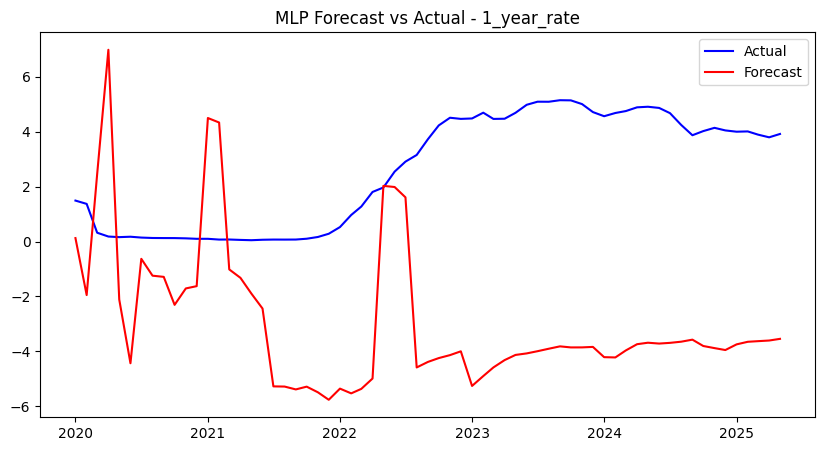


MLP Forecasting: 3_months_rate


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
📊 Results: MAE=2.3063, RMSE=2.7378, MAPE=1163.56%


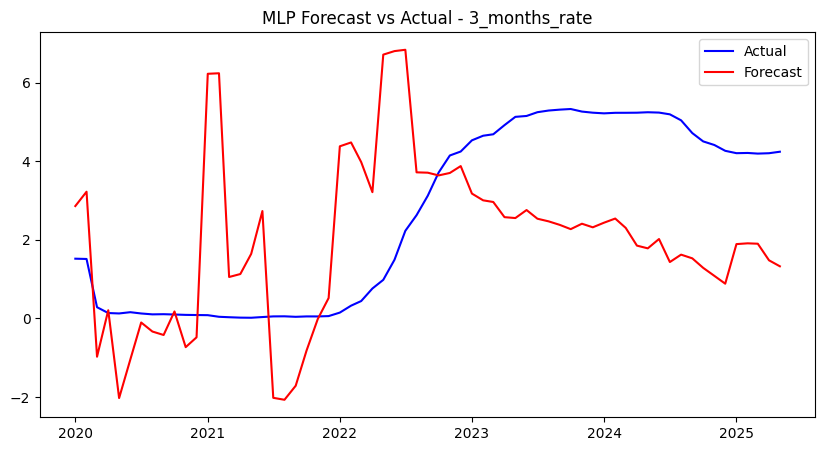


MLP Forecasting: 6_months_rate


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
📊 Results: MAE=2.0482, RMSE=2.5138, MAPE=466.14%


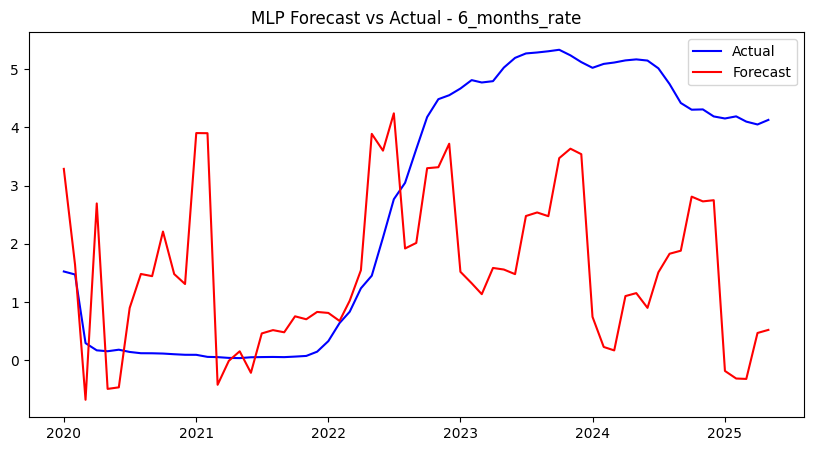


MLP Forecasting: CPI


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
📊 Results: MAE=33.3500, RMSE=39.3385, MAPE=11.56%


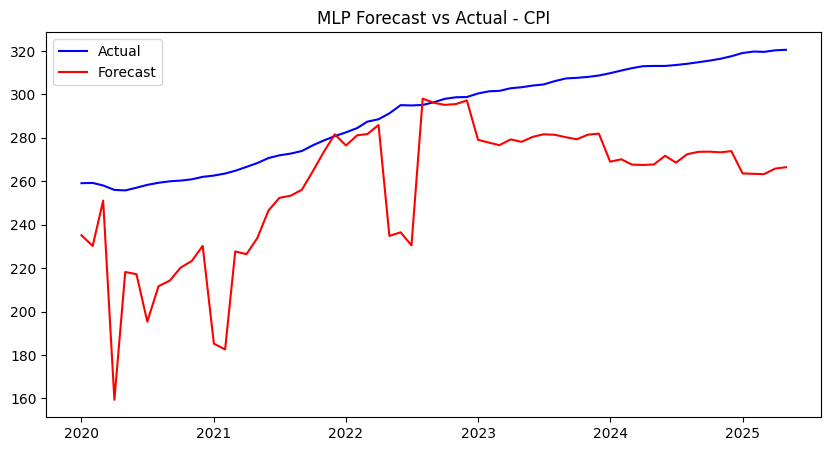


MLP Forecasting: INDPRO


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
📊 Results: MAE=5.1794, RMSE=5.9817, MAPE=5.18%


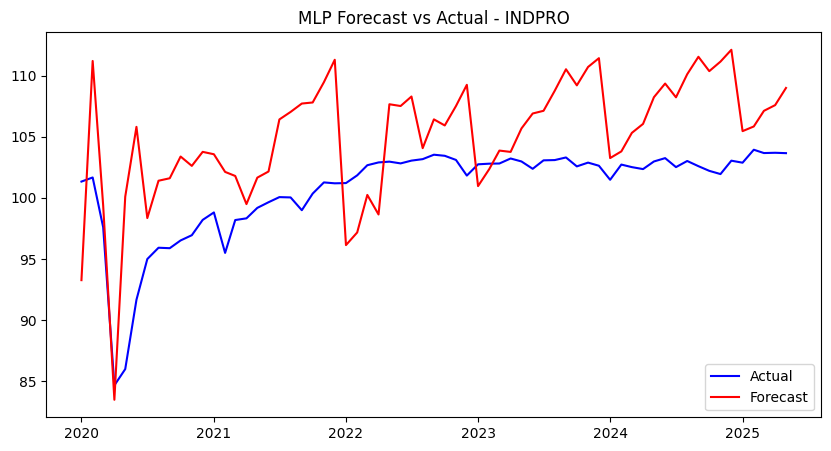


MLP Forecasting: 10_year_rate


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
📊 Results: MAE=2.0249, RMSE=2.6498, MAPE=149.59%


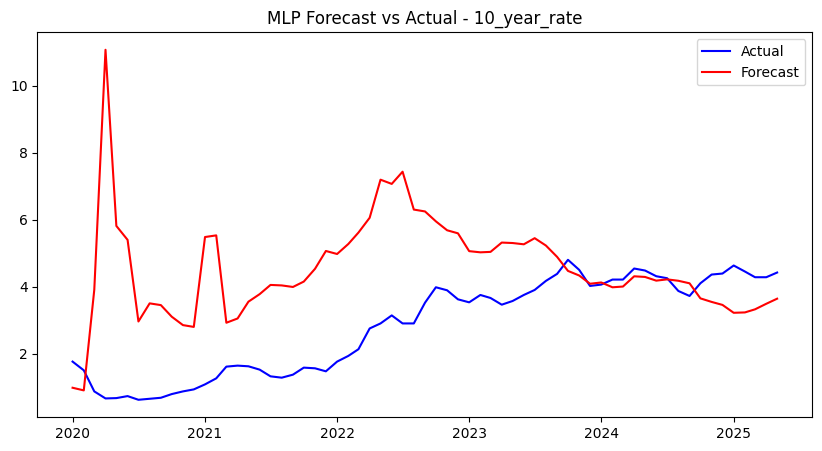


MLP Forecasting: share_price


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
📊 Results: MAE=0.6792, RMSE=0.9178, MAPE=10.22%


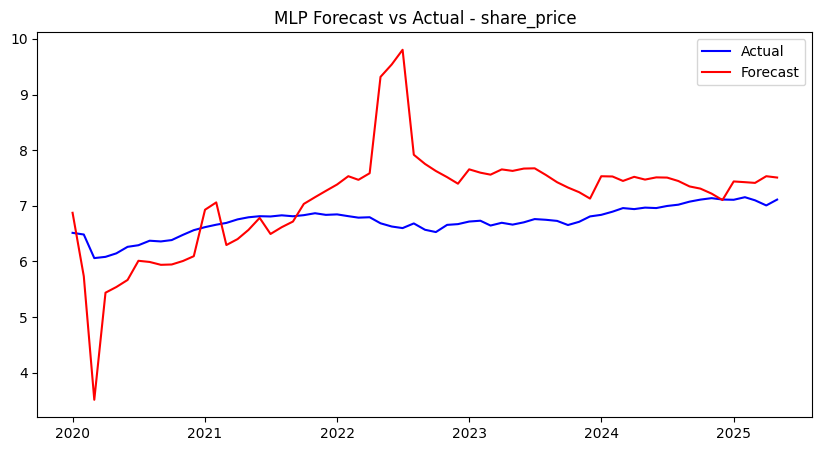


MLP Forecasting: unemployment_rate


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
📊 Results: MAE=0.8840, RMSE=1.1593, MAPE=18.15%


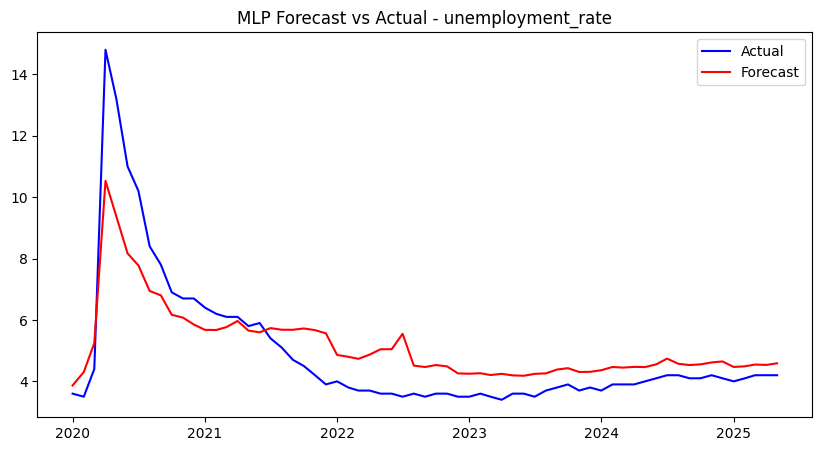


MLP Forecasting: PPI


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
📊 Results: MAE=62.5468, RMSE=83.2134, MAPE=12.15%


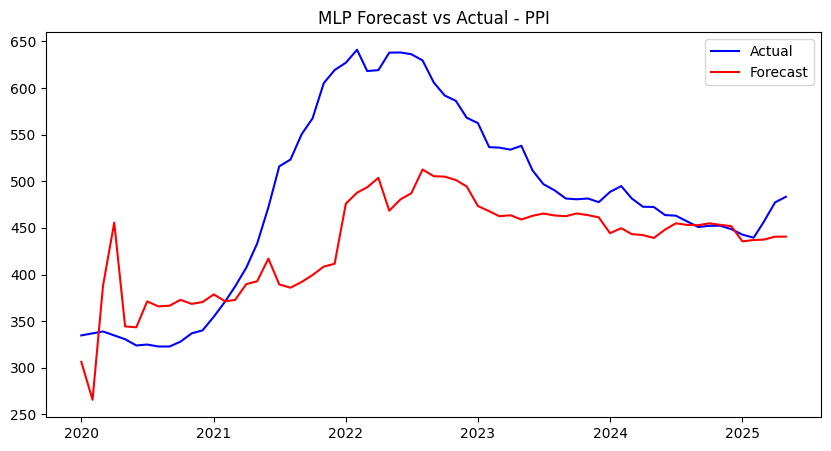


MLP Forecasting: OECD_CLI_index


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
📊 Results: MAE=0.8941, RMSE=1.1884, MAPE=0.90%


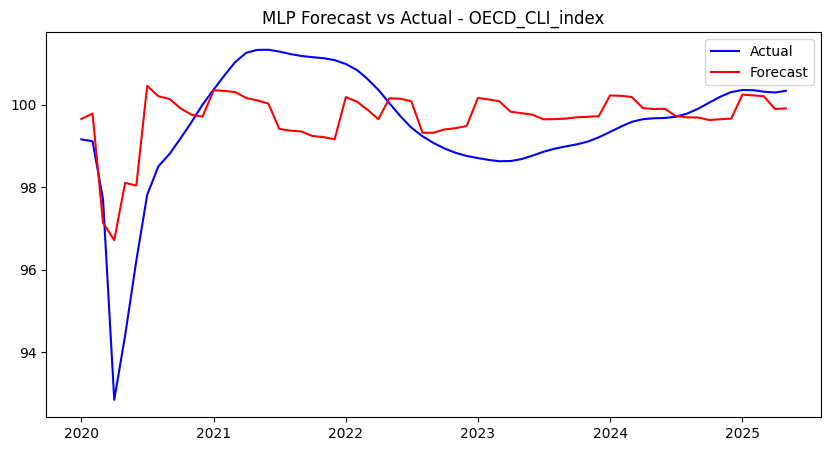


MLP Forecasting: CSI_index


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
📊 Results: MAE=12.4690, RMSE=14.0722, MAPE=18.95%


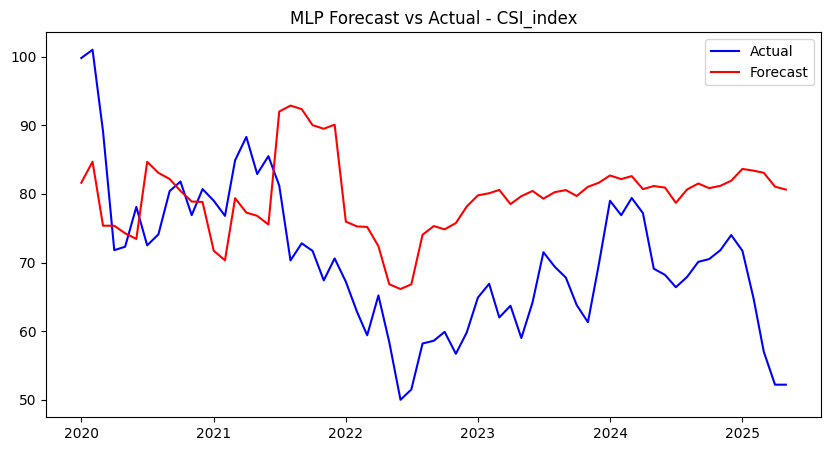


MLP Forecasting: gdp_per_capita


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
📊 Results: MAE=4464.5248, RMSE=9285.3969, MAPE=9984095552889.92%


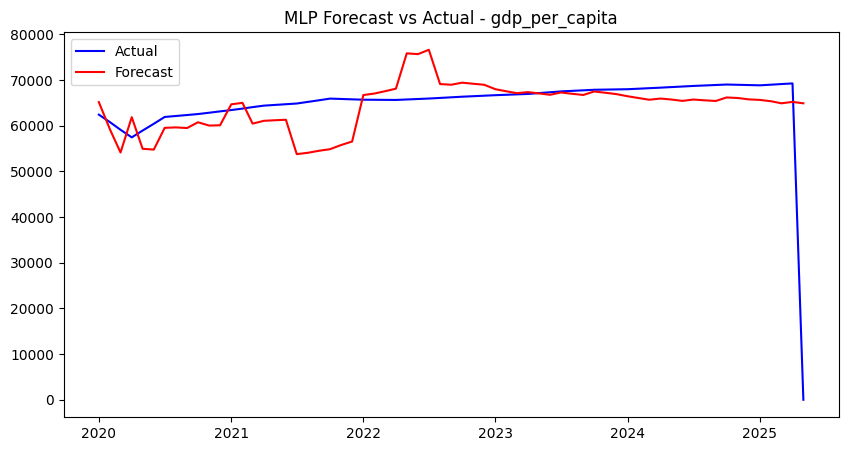

In [13]:
# -----------------------------
# USAGE
# -----------------------------
results = run_mlp_pipeline(dim_reduced_df, financial_indicators, include_exog=True)